## Step 1: Check Environment is up to date 

In [8]:
!pip install -Uqq fastai duckduckgo_search

#what photo do we want our model to recognize?
serach_term = 'football'

## Step 2: Download images you want to use 

Searching for 'football photos'


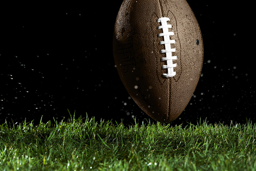

In [9]:
#installs necessary python packages 
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

#function that will search duckduckgo for images and return a list containing the photo 
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


urls = search_images(serach_term + ' photos', max_images=1)
dest = f'{serach_term}.jpg'
download_url(urls[0], dest, show_progress=False)

#prints photo to concole 
im = Image.open(dest)
im.to_thumb(256,256)

## Step 3: Collect different types of photos to train our model 

In [ ]:
searches = 'cat', serach_term
path = Path('what_is_the_photo')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cat photo'
Searching for 'cat sun photo'
Searching for 'cat shade photo'
Searching for 'football photo'


## Step 4: Model training setup

### To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training).

In [ ]:
#sometimes we get unusable images that will break our code. We use the code below to remove those images 
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(len(failed))

#creates a data block that is split into trainig and validation sets
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

#show data block
dls.show_batch(max_n=20)

## Step 5: Model Training 

### Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds) Fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

### "Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) 


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## Step 6: Testing and Using the model 

In [ ]:
# Lets look back at our photo from earlier 
im = Image.open(f'{serach_term}.jpg')
im.to_thumb(256,256)

In [ ]:
#Lets run our model and see if it recognizes our photo as a bird
is_photo,_,probs = learn.predict(f'{serach_term}.jpg')
print(f"This is a: {is_photo}.")
print(f"Probability it's a {serach_term}: {probs[0]:.10f}")
im = Image.open(f'{serach_term}.jpg')
im.to_thumb(256,256)